----
# Minumum number of features for SVM classification
----

In [73]:
#import libraries
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

import pandas as pd

import standardization as sd                                #Self written, Scikit-learn do have standardScaler which does the same.
import confusion_matrix
from sklearn.metrics import confusion_matrix as cf

UseTex = True
if UseTex:
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "cmr"
    })


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
#smaller dataset for feature selection
for_feature_selection = pd.read_csv("../TrainingData/neodata/fault_all_10.csv")

# Load training data
train_data = pd.read_csv("../TrainingData/neodata/fault_all_no_noise_100.csv")
test_data = pd.read_csv("../TestData/neodata/fault_all_no_noise_100.csv")
vald_data=pd.read_csv("../ValidationData/neodata/fault_all_no_noise_100.csv")

In [75]:
Drop_8_18 = True

if Drop_8_18:
    train_data = train_data[ (train_data['target'] != 8) & (train_data['target'] != 18) ]
    test_data = test_data[ (test_data['target'] != 8) & (test_data['target'] != 18) ]
    vald_data = vald_data[ (vald_data['target'] != 8) & (vald_data['target'] != 18) ]

train_data['target'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       19, 20], dtype=int64)

In [76]:
#Normalization / conditioning
standardizer = sd.standardization(train_data,'target')

fts = standardizer.transform(for_feature_selection)
trn = standardizer.transform(train_data)
tst = standardizer.transform(test_data)
val = standardizer.transform(vald_data)

targets = train_data['target'].unique().tolist()        # List of classes

labels_tst = test_data['target']


SVM classifier on 10 point dataset to evaluate which features to drop

In [77]:
from sklearn import svm

clf0 = svm.SVC( kernel="rbf", decision_function_shape="ovo", C=1000, gamma=0.01)
clf0.fit(fts.drop('target',axis=1), fts['target'])


SVC(C=1000, decision_function_shape='ovo', gamma=0.01)

Sequential feature selector to select important features

In [78]:
from sklearn.feature_selection import SequentialFeatureSelector

features = 5

bw = SequentialFeatureSelector(clf0,direction='backward',n_jobs=8,n_features_to_select=features)

In [79]:
bw.fit(fts.drop('target',axis=1), fts['target'])  #might take more than 30 seconds

SequentialFeatureSelector(direction='backward',
                          estimator=SVC(C=1000, decision_function_shape='ovo',
                                        gamma=0.01),
                          n_features_to_select=5, n_jobs=8)

Which features are dropped?

In [80]:
labels = trn.drop('target',axis=1).columns
dropped = labels[np.invert(bw.get_support())]
dropped

Index(['Pdis', 'Psuc', 'T0', 'Tsh', 'Tsup', 'CondFan', 'CprPower', 'Density',
       'Tamb'],
      dtype='object')

How the remaining dataset looks like

In [81]:
trn_reduced = trn.drop(dropped,axis=1)
tst_reduced = tst.drop(dropped,axis=1)
val_reduced = val.drop(dropped,axis=1)
trn_reduced

Tc      Tdis      Tret      Tsuc   Density      Tset  target
0     -1.072921 -0.352162 -0.933854 -0.976516 -0.466804 -1.286824       0
1     -1.072354 -0.351494 -0.933740 -0.976473 -0.467020 -1.286824       0
2     -1.073034 -0.352289 -0.933880 -0.976529 -0.466765 -1.286824       0
3     -1.073213 -0.352488 -0.933923 -0.976551 -0.466706 -1.286824       0
4     -1.073494 -0.352792 -0.933994 -0.976591 -0.466617 -1.286824       0
...         ...       ...       ...       ...       ...       ...     ...
37795  3.613831  1.764683  0.381933  0.458137 -0.076163  1.151368      20
37796  3.614030  1.764905  0.381914  0.458115 -0.076269  1.151368      20
37797  3.613967  1.764835  0.381920  0.458122 -0.076235  1.151368      20
37798  3.614725  1.765666  0.381856  0.458050 -0.076620  1.151368      20
37799  3.615031  1.765993  0.381835  0.458026 -0.076767  1.151368      20

[34200 rows x 7 columns]

Training a full classifier on more datapoint with the features dropped

In [82]:
clf = svm.SVC( kernel="rbf", decision_function_shape="ovo", C=1000, gamma=0.01)
clf.fit(trn_reduced.drop('target',axis=1), trn_reduced['target'])

SVC(C=1000, decision_function_shape='ovo', gamma=0.01)

In [83]:
#predicting
predict = clf.predict(trn_reduced.drop('target',axis=1))

print(trn_reduced['target'].to_numpy())
print(predict)

[ 0  0  0 ... 20 20 20]
[ 0  0  0 ... 20 20 20]


c:\Users\klepa\OneDrive\Dokumentumok\AAU\Project\p7-ml-refrigeration-fault-detection\Python\confusion_matrix.py:25: RuntimeWarning: invalid value encountered in true_divide
  axs.imshow(np.sqrt(conf_matrix/np.outer(conf_matrix.sum(axis=1),np.ones(width))),cmap="Greens")


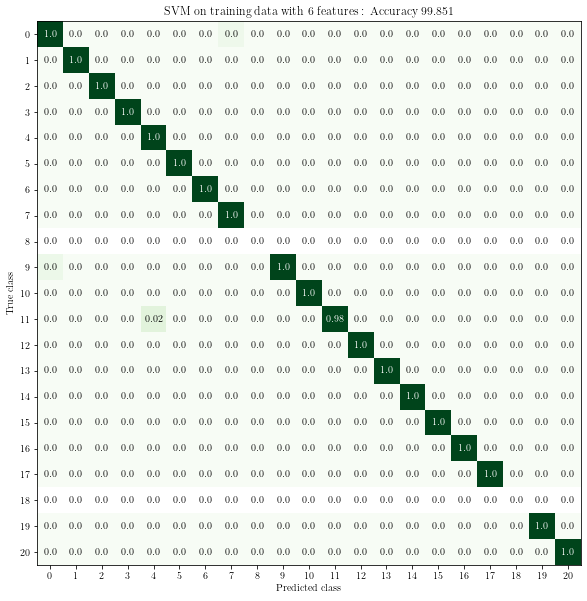

In [84]:
conf_matrix = np.zeros([21, 21])

for x,y in zip(predict,trn_reduced['target']):
    conf_matrix[int(y)][int(x)] +=1

#     #Generate confusion matrix pdf
confusion_matrix.confusion_matrix(conf_matrix, figsize = (10,10), title = f'SVM on training data with {features} features',eval_labels = False)
pass

In [85]:
#predicting
predict_val = clf.predict(val_reduced.drop('target',axis=1))

print(val_reduced['target'].to_numpy())
print(predict_val)

[ 0  0  0 ... 20 20 20]
[ 0  0  0 ... 20 20 20]


c:\Users\klepa\OneDrive\Dokumentumok\AAU\Project\p7-ml-refrigeration-fault-detection\Python\confusion_matrix.py:25: RuntimeWarning: invalid value encountered in true_divide
  axs.imshow(np.sqrt(conf_matrix/np.outer(conf_matrix.sum(axis=1),np.ones(width))),cmap="Greens")


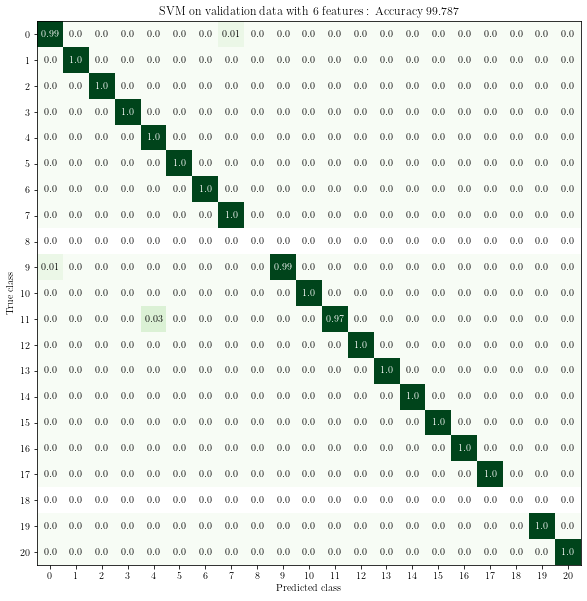

In [86]:
conf_matrix = np.zeros([21, 21])

for x,y in zip(predict_val,val_reduced['target']):
    conf_matrix[int(y)][int(x)] +=1

    #Generate confusion matrix pdf
confusion_matrix.confusion_matrix(conf_matrix, figsize = (10,10), title = f'SVM on validation data with {features} features',eval_labels = False,save_fig_name='PDF/SVM validation with all features.pdf')
pass

In [87]:
#predicting
predict_tst = clf.predict(tst_reduced.drop('target',axis=1))

print(val_reduced['target'].to_numpy())
print(predict_tst)

[ 0  0  0 ... 20 20 20]
[ 0  0  0 ... 20 20 20]


c:\Users\klepa\OneDrive\Dokumentumok\AAU\Project\p7-ml-refrigeration-fault-detection\Python\confusion_matrix.py:25: RuntimeWarning: invalid value encountered in true_divide
  axs.imshow(np.sqrt(conf_matrix/np.outer(conf_matrix.sum(axis=1),np.ones(width))),cmap="Greens")


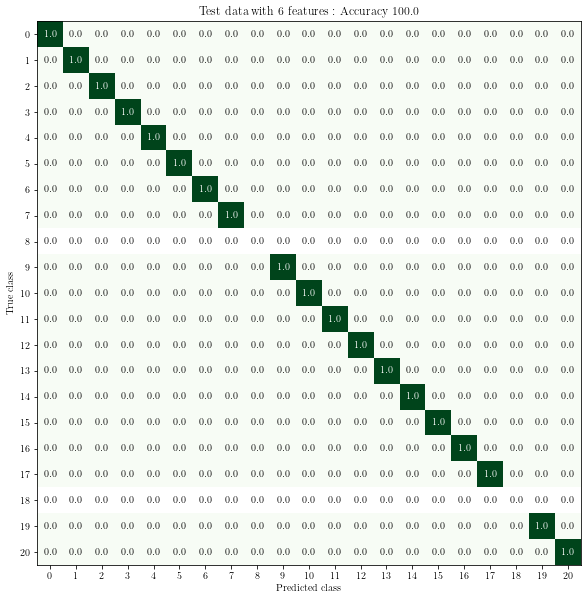

In [88]:
conf_matrix = np.zeros([21, 21])

for x,y in zip(predict_tst,tst_reduced['target']):
    conf_matrix[int(y)][int(x)] +=1

    #Generate confusion matrix pdf
confusion_matrix.confusion_matrix(conf_matrix, figsize = (10,10), title = f'Test data with {features} features',eval_labels = False, save_fig_name='PDF/SVM test with all features.pdf')
pass

# Extra:<br>
plot accuracies against the number of features (takes some time)

In [22]:
Run_now = True #Run feature selection or load previous results

CSV_path = 'forward_reduction.csv'

from os.path import exists
exist = exists(CSV_path)

if Run_now or not exist:
    from sklearn.feature_selection import SequentialFeatureSelector
    accuracies_forw = pd.DataFrame({'n_features':[],'val':[],'tst':[]}) #init dataframe
    for i in range(2,14):
        bw = SequentialFeatureSelector(clf0,direction='forward',n_jobs=10,n_features_to_select=i) 
        bw.fit(fts.drop('target',axis=1), fts['target'])
        print(f"{i} features")
        labels = trn.drop('target',axis=1).columns
        dropped = labels[np.invert(bw.get_support())]

        trn_reduced = trn.drop(dropped,axis=1)
        tst_reduced = tst.drop(dropped,axis=1)
        val_reduced = val.drop(dropped,axis=1)

        clf = svm.SVC( kernel="rbf", decision_function_shape="ovo", C=1000, gamma=0.01)
        clf.fit(trn_reduced.drop('target',axis=1), trn_reduced['target'])

        val_score = clf.score(val_reduced.drop('target',axis=1),val_reduced['target'])
        test_score = clf.score(tst_reduced.drop('target',axis=1),tst_reduced['target'])
        print(f"val:{val_score} test:{test_score}")
        accuracies_forw = accuracies_forw.append({'n_features':i,'val':val_score,'tst':test_score},ignore_index=True)

    accuracies_forw.to_csv(CSV_path)

else:
    accuracies_forw = pd.read_csv(CSV_path)

accuracies_forw

2
val:0.31415343915343913 test:0.26
3
val:0.5491005291005291 test:0.3742857142857143
4
val:0.6314285714285715 test:0.47619047619047616
5
val:0.8518518518518519 test:0.6190476190476191
6
val:0.8823280423280423 test:0.7619047619047619
7
val:0.9044708994708994 test:0.8571428571428571
8
val:0.9063227513227513 test:0.8571428571428571
9
val:0.9062962962962963 test:0.8571428571428571
10
val:0.9087830687830688 test:0.8571428571428571
11
val:0.9060317460317461 test:0.8571428571428571
12
val:0.9082010582010582 test:0.8571428571428571
13
val:0.9061111111111111 test:0.8571428571428571


,n_features,val,tst
0,2.0,0.314153,0.260000
1,3.0,0.549101,0.374286
2,4.0,0.631429,0.476190
3,5.0,0.851852,0.619048
4,6.0,0.882328,0.761905
5,7.0,0.904471,0.857143
6,8.0,0.906323,0.857143
7,9.0,0.906296,0.857143
8,10.0,0.908783,0.857143
9,11.0,0.906032,0.857143


In [72]:
Run_now = True #Run feature selection or load previous results

CSV_path = 'backward_reduction.csv'

from os.path import exists
exist = exists(CSV_path)

if Run_now or not exist:
    from sklearn.feature_selection import SequentialFeatureSelector
    accuracies_backw = pd.DataFrame({'n_features':[],'val':[],'tst':[]}) #init dataframe
    for i in range(2,14):
        bw = SequentialFeatureSelector(clf0,direction='backward',n_jobs=10,n_features_to_select=i) 
        bw.fit(fts.drop('target',axis=1), fts['target'])
        print(f"{i} features")
        labels = trn.drop('target',axis=1).columns
        dropped = labels[np.invert(bw.get_support())]

        trn_reduced = trn.drop(dropped,axis=1)
        tst_reduced = tst.drop(dropped,axis=1)
        val_reduced = val.drop(dropped,axis=1)

        clf = svm.SVC( kernel="rbf", decision_function_shape="ovo", C=1000, gamma=0.01)
        clf.fit(trn_reduced.drop('target',axis=1), trn_reduced['target'])

        val_score = clf.score(val_reduced.drop('target',axis=1),val_reduced['target'])
        test_score = clf.score(tst_reduced.drop('target',axis=1),tst_reduced['target'])
        print(f"val:{val_score} test:{test_score}")
        accuracies_backw = accuracies_backw.append({'n_features':i,'val':val_score,'tst':test_score},ignore_index=True)
    accuracies_backw.to_csv(CSV_path)

else:
    accuracies_backw = pd.read_csv(CSV_path)

accuracies_backw

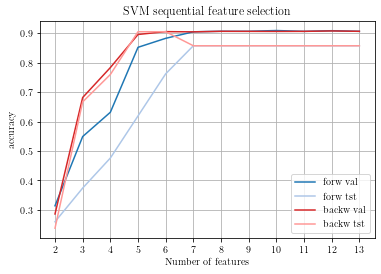

In [71]:
import matplotlib
col = matplotlib.colormaps['tab20']

plt.figure(figsize=(6,4)) #(6,4) good size for the report
plt.plot(accuracies_forw['n_features'],accuracies_forw['val'],c=col.colors[0])
plt.plot(accuracies_forw['n_features'],accuracies_forw['tst'],c=col.colors[1])


plt.plot(accuracies_backw['n_features'],accuracies_backw['val'],c=col.colors[6])
plt.plot(accuracies_backw['n_features'],accuracies_backw['tst'],c=col.colors[7])

plt.ylabel('accuracy')
plt.xlabel('Number of features')
plt.title('SVM sequential feature selection')
plt.legend(['forw val','forw tst','backw val','backw tst'])
plt.grid(True)
plt.xticks(range(2,14))

plt.savefig('PDF/Feature Selection.pdf')

### Observation:
using 5-6 features, the svm classifier successfully classifies the faults. further increasing the features does not yield higher classification accuracy.<br>